<a href="https://colab.research.google.com/github/jscienciadados/Simulacao-Monte_Carlo/blob/main/Monte_Carlo_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estudo Dirigido - Simulação de Monte Carlo e Séries Temporais para Modelagem Financeira

In [2]:
# Versão da linguagem python
from platform import python_version
print('versão da linguagem python usada neste jupyter notebook: ', python_version())

versão da linguagem python usada neste jupyter notebook:  3.7.10


# Carregando os Pacotes

In [7]:
# Imports
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as m 
import seaborn as sns

import scipy
from scipy.stats import kurtosis, skew, shapiro
import warnings
warnings.filterwarnings("ignore")

# Imports para formatação dos graficos
plt.style.use('fivethirtyeight')
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10


Carregando os Dados

In [9]:
# Obs: O valor das açoes foi ajustado para facilitar a criação dos graficos.
dados = pd.read_csv("data/dataset.csv", parse_dates= True, index_col= "Data")

In [10]:
# Visualizando os primeiros registros
dados.head()

,Abertura,Fechamento,Maximo,Minimo,Volume,Mudanca(%)
Data,,,,,,
2020-03-10,276.0,270.3,280.0,268.0,109.42,0.00
2020-03-10,275.0,270.3,280.0,268.0,124.56,0.11
2020-03-09,266.0,270.0,284.0,259.5,191.21,-7.91
2020-03-06,294.6,293.2,294.9,283.0,104.89,-1.48
2020-03-05,303.0,297.6,305.5,294.2,90.58,0.68


In [11]:
# Tipos de Dados
dados.dtypes

Abertura      float64
Fechamento    float64
Maximo        float64
Minimo        float64
Volume        float64
Mudanca(%)    float64
dtype: object

In [12]:
# shape
dados.shape

(5037, 6)

In [13]:
# Sumário estatístico
dados.describe()

,Abertura,Fechamento,Maximo,Minimo,Volume,Mudanca(%)
count,5037.000000,5037.000000,5037.000000,5037.000000,5037.000000,5037.000000
mean,35.002488,35.001910,35.589655,34.377016,9.748444,0.152400
std,62.600066,62.596556,63.605892,61.530026,26.663983,4.423538
min,0.640000,0.640000,0.670000,0.620000,0.000000,-61.630000
25%,2.960000,2.980000,3.050000,2.900000,0.310000,-1.520000
50%,6.320000,6.280000,6.460000,6.130000,1.230000,0.000000
75%,25.820000,25.890000,26.270000,25.530000,5.840000,1.490000
max,330.600000,331.000000,336.000000,326.600000,711.800000,48.070000


# Visualizando o Preço Diário de Fechamento das Ações no Tempo

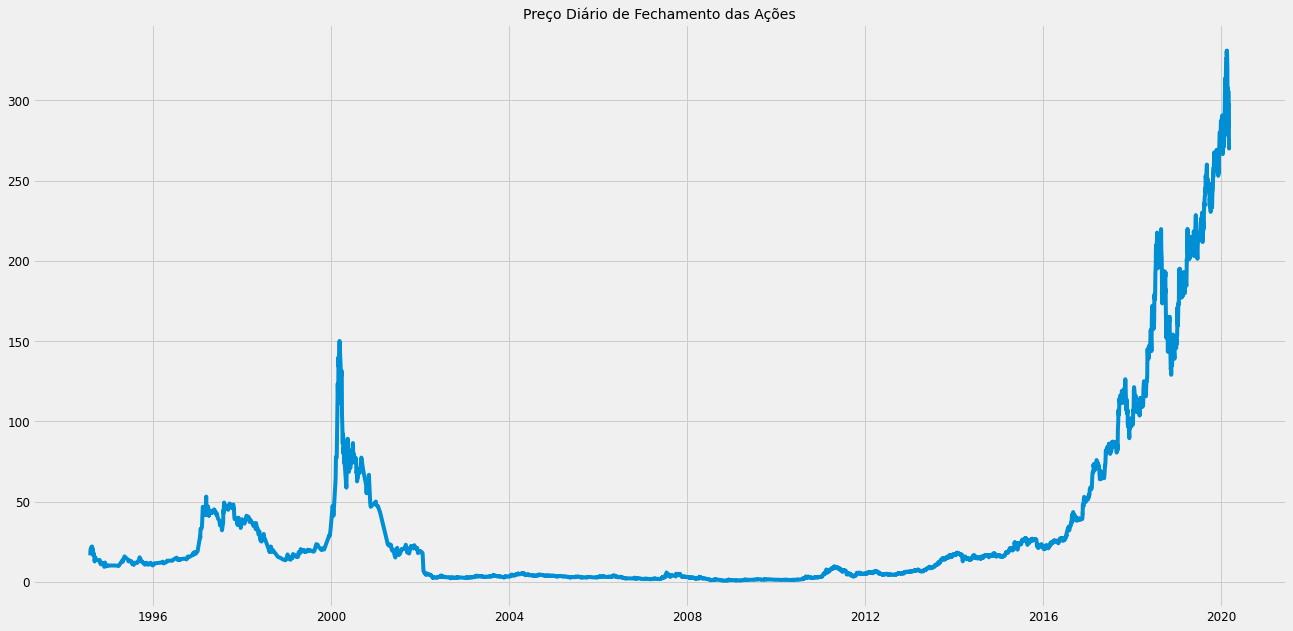

In [14]:
# Plot
plt.plot(dados["Fechamento"])
plt.title("Preço Diário de Fechamento das Ações", size = 14)
plt.show()

Calculo do retorno diário da Série

In [15]:
# Calculando o percentual de mudança na cotação de fechamento diario das açoes
# ou seja, quanto o valor de fechamento varia de um dia para o outro.
retorno_diario = dados["Fechamento"].pct_change().dropna()
retorno_diario.head()

Data
2020-03-10    0.000000
2020-03-09   -0.001110
2020-03-06    0.085926
2020-03-05    0.015007
2020-03-04   -0.006720
Name: Fechamento, dtype: float64

Calculo do retorno acumulado da série.

In [16]:
retorno_diario_acumulado = (1 + retorno_diario).cumprod() -1
retorno_diario_acumulado.max()

0.2245652978172401

# <font color = "blue">Análise Exploratória e Estatística Descritiva</font>

Calculo do retorno médio e a variação (desvio padrão)

In [17]:
# Media do fechamento diário da cotação das ações
media_retorno_diario = np.mean(retorno_diario)

# Desvio Padrão do fechamento diário da cotação das ações
desvio_retorno_diario = np.std(retorno_diario)

In [18]:
# Media e desvio padrão
print("Média do Retorno de Fechamento:", media_retorno_diario)
print("Desvio Padrão do Retorno de Fechamento:", desvio_retorno_diario)

Média do Retorno de Fechamento: 0.00045753294896881046
Desvio Padrão do Retorno de Fechamento: 0.047851416559428164


Considerar o ano com 252 dias de funcionamento da bolsa americana

In [19]:
print("Retorno Média Anualizado de Fechamento:", (1 + media_retorno_diario) ** 252 -1)
print("Desvio Padrão Anualizado de Fechamento:", desvio_retorno_diario*np.sqrt(252))

Retorno Média Anualizado de Fechamento: 0.12217855548103884
Desvio Padrão Anualizado de Fechamento: 0.7596176885904296


Embora nos últimos anos a performance das ações tenha sido boa, na média o ganho tem sido baixo, embora positivo. No longo prazo o investidor não perdeu dinheiro

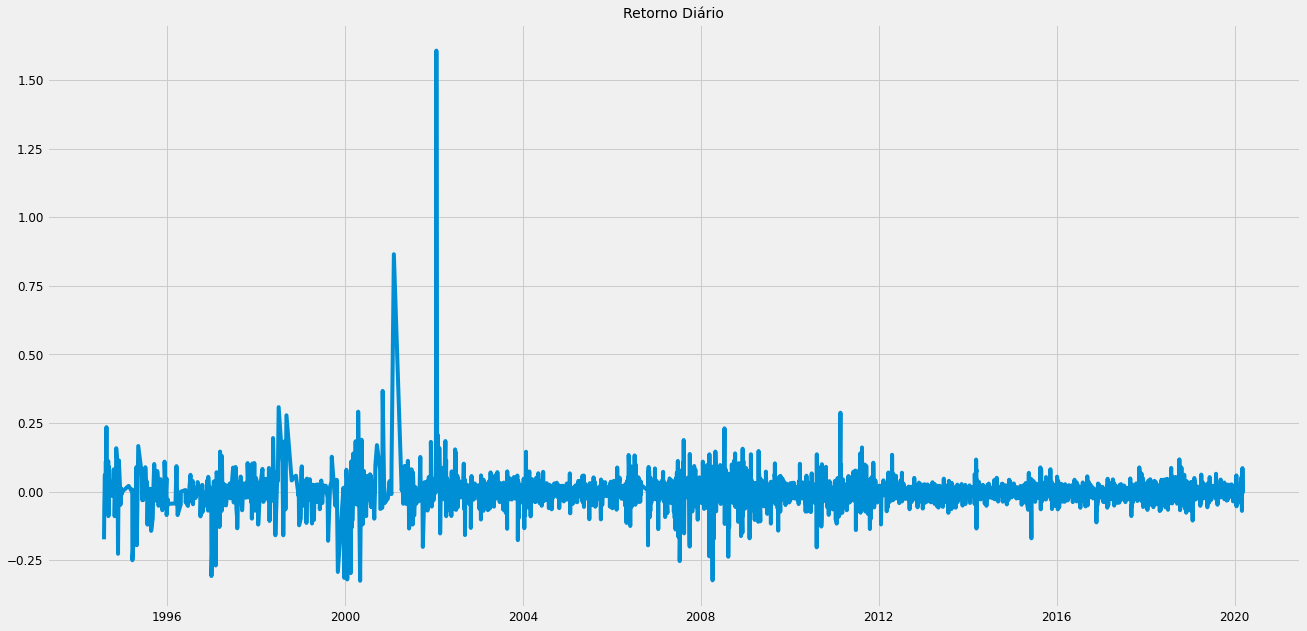

In [20]:
# Plot -> com retorno diario
plt.plot(retorno_diario)
plt.title("Retorno Diário", size = 14)
plt.show()

Com apenas duas grandes variações, o retorno diario tem sido constante ao longo do tempo.

Criamos um histograma com a distribuição do retorno diário.

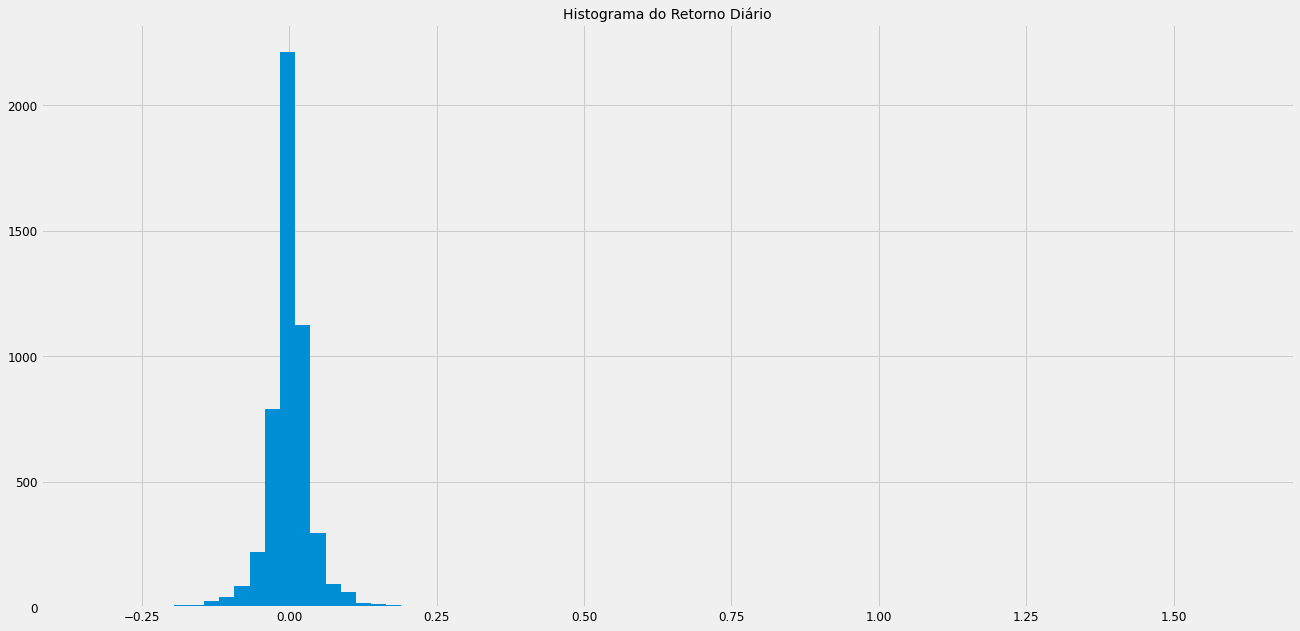

In [21]:
plt.hist(retorno_diario, bins= 75)
plt.title("Histograma do Retorno Diário", size = 14)
plt.show()

Os valores estão bem próximos mesmo da média. Mas vamos confirmar isso calculando curtose e assimetria.

In [22]:
# Curtose e Assimetria
print("Curtose: ", kurtosis(retorno_diario))
print("Assimetria: ", skew(retorno_diario))

Curtose:  278.4606940718125
Assimetria:  8.379693825200768


A curtose indica que os registros estão bem próximos da média. Mas a assimetria indica que os dados estão bem distorcidos e distantes de uma distribuição normal. Vamos aplicar o teste de normalidade na série.

# Teste de Normalidade shapiro-wilk

In [23]:
# executa o teste de normalidade para a série
teste_normalidade = shapiro(retorno_diario)[1]

# Verifica o retorno com base no valor-p de 0.05
if teste_normalidade <= 0.05:
  print("Rejeitamos a Hipótese Nula de Normalidade dos Dados.")
else:
  print("Falhamos em Rejeitar a Hipótese Nula de Normalidade dos Dados.")  


Rejeitamos a Hipótese Nula de Normalidade dos Dados.


Como imaginávamos a distribuição não é normal. Vamos aplicar uma transformação de log à série e então aplicar a técnica de diferenciação para retirar da série os padrões de tendência e deixarmos apenas os dados reais, que nos interessam. Com isso calculamos o retorno diário.


In [24]:
# Transformação de log e diferenciação para cálculo do retorno diário
log_retorno_diario = (np.log(dados["Fechamento"]) - np.log(dados["Fechamento"]).shift(-1)).dropna()

# Cálculo da média e desvio padrão após a transformação
log_media_retorno_diario = np.mean(log_retorno_diario)
log_desvio_retorno_diario = np.std(log_retorno_diario)

Plot do retorno diário da série transformada.

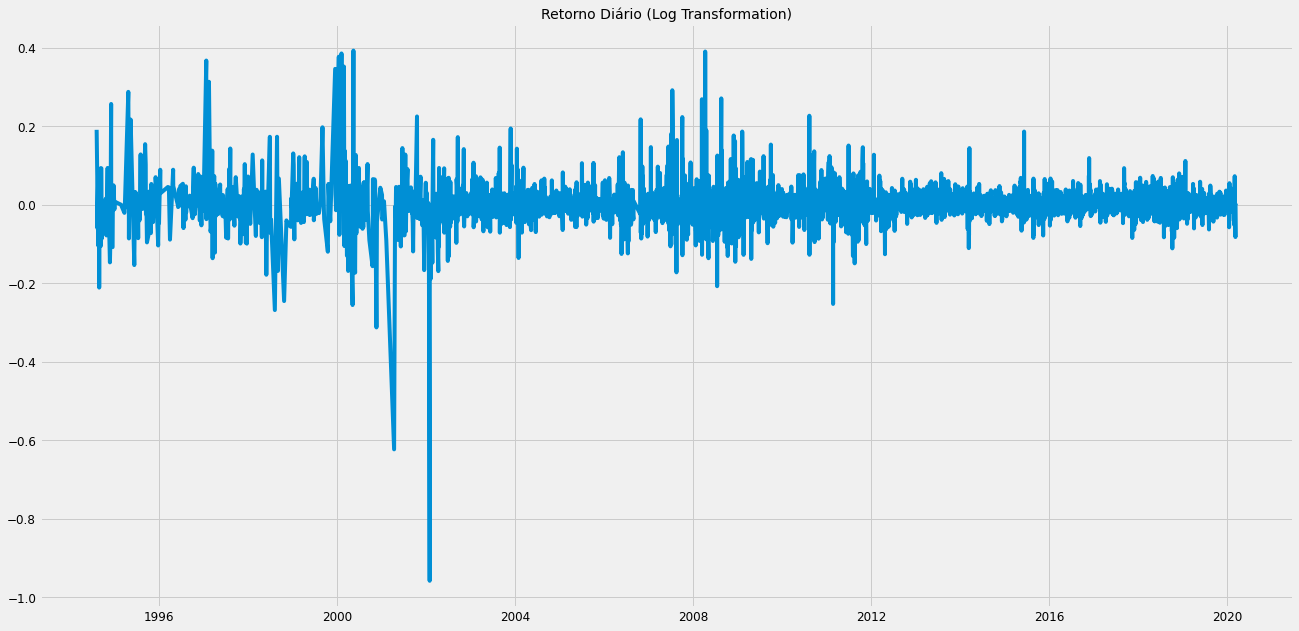

In [25]:
# Plot
plt.plot(log_retorno_diario)
plt.title("Retorno Diário (Log Transformation)", size = 14)
plt.show()

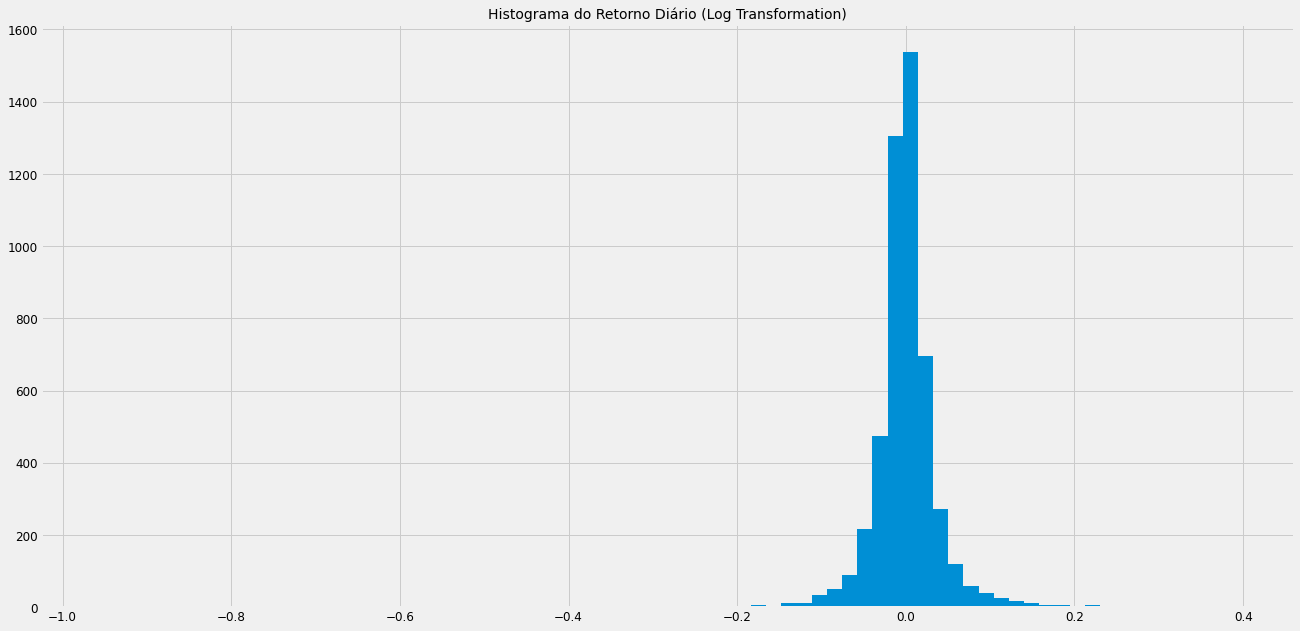

In [26]:
# Histograma
plt.hist(log_retorno_diario, bins= 75)
plt.title("Histograma do Retorno Diário (Log Transformation)", size = 14)
plt.show()

In [28]:
# Calculamos a curtose e assimetria
print("Curtose: ", kurtosis(log_retorno_diario))
print("Assimetria: ", skew(log_retorno_diario))

Curtose:  63.102709019136654
Assimetria:  -1.3916921515501128


In [29]:
# Executa o teste de normalidade para a série
teste_normalidade = shapiro(log_retorno_diario)[1]

# Verifica o retorno com base no valor-p de 0.05
if teste_normalidade <= 0.05:
  print("Rejeitamos a Hipótese Nula de Normalidade dos Dados.")
else:
  print("Falhamos em Rejeitar a Hipótese Nula de Normalidade dos Dados.")  

Rejeitamos a Hipótese Nula de Normalidade dos Dados.


Os dados ainda não são normais, porém reduzimos a distorção dos dados. Poderíamos aplicar outras transformações, mas para o objetivo este estudo isso é suficiente. Seguimos com a série transformada.

# <font color = "red">Valor Histórico</font>

Cálculo do valor histórico do preço da ação.

In [30]:
# Nível de Variância
var_level = 95
var = np.percentile(log_retorno_diario, 100 - var_level)
print("Certeza de que as perdas diárias não excederão o VaR% em um determinado dia com base em valores históricos.")
print("VaR 95%", var)

Certeza de que as perdas diárias não excederão o VaR% em um determinado dia com base em valores históricos.
VaR 95% -0.05391118257211601


In [31]:
# Var para os próximos 5 dias
var * np.sqrt(5)

-0.12054906897865336

# Valor Histórico Condicional

In [32]:
# Nível de variância
var_level = 95
var = np.percentile(log_retorno_diario, 100 - var_level)
cvar = log_retorno_diario[log_retorno_diario < var].mean()
print("Nos piores 5% dos casos, as perdas foram, em média, superiores ao percentual histórico.")
print("CVaR 95%", cvar)

Nos piores 5% dos casos, as perdas foram, em média, superiores ao percentual histórico.
CVaR 95% -0.09528907737617054


# <font color = "green">Monte Carlo Simulation</font>

In [33]:
# Simulação de Monte Carlo

# Número de dias a frente
dias_posteriores = 252

# Número de simulações
simulacoes = 2500

# Último valor da ação
ultimo_preco = 270.3

# Cria um array vazio com as dimensões
results = np.empty((simulacoes, dias_posteriores))

# Loop por cada simulação
for s in range(simulacoes):
   
    # Calcula o retorno com dados randômicos seguindo uma distribuição normal
    random_returns = 1 + np.random.normal(loc = log_media_retorno_diario,
                                          scale = log_desvio_retorno_diario,
                                          size = dias_posteriores)
   
    result = ultimo_preco * (random_returns.cumprod())
   
    results[s, :] = result

In [34]:
# Definindo o indice da série simulada
index = pd.date_range("2020-03-11", periods= dias_posteriores, freq= "D")
resultados = pd.DataFrame(results.T, index= index)
media_resultados = resultados.apply("mean", axis = 1)

# Resultado da Simulando de Monte Carlo

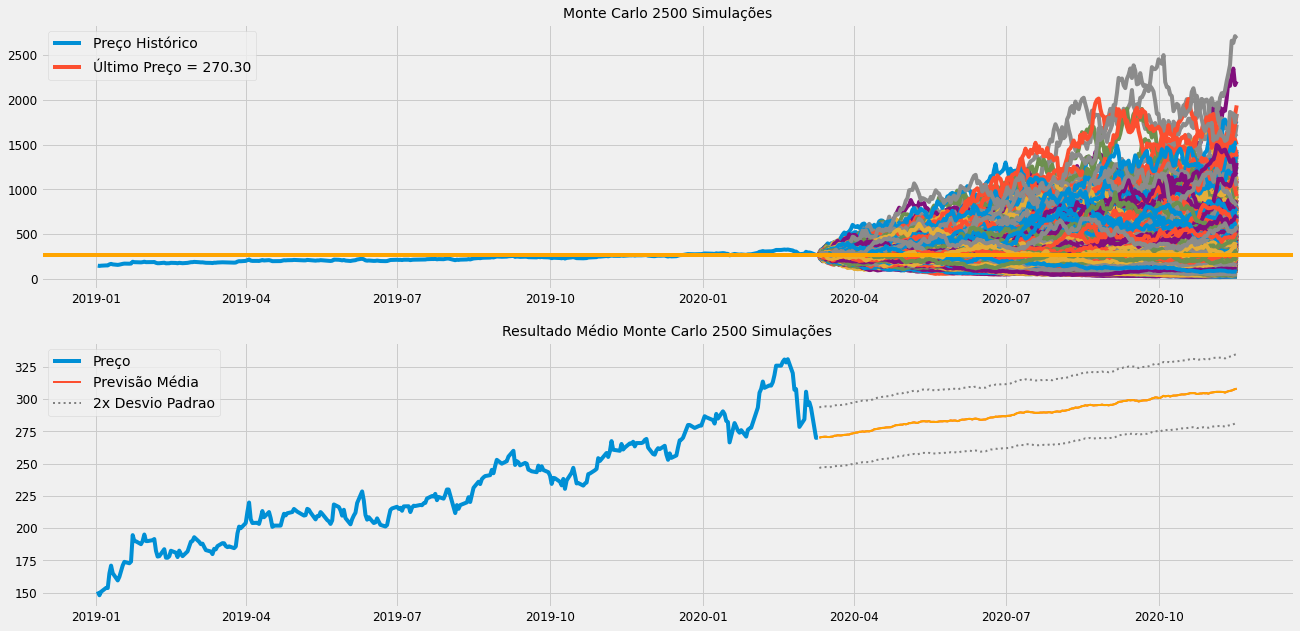

In [35]:
# Dividindo a área de plotagem em 2 subplots
fig, ax = plt.subplots(nrows = 2, ncols = 1)

# Plot
ax[0].plot(dados["Fechamento"][:"2018-12-31"])

ax[0].plot(resultados)

ax[0].axhline(270.30, c = "orange")

ax[0].set_title(f"Monte Carlo {simulacoes} Simulações", size = 14)

ax[0].legend(["Preço Histórico", "Último Preço = 270.30"])

ax[1].plot(dados["Fechamento"][:"2018-12-31"])

ax[1].plot(resultados.apply("mean", axis = 1), lw = 2)

ax[1].plot(media_resultados.apply((lambda x: x * (1+1.96 * log_desvio_retorno_diario))),
           lw = 2, linestyle = "dotted", c = "gray")

ax[1].plot(media_resultados, lw = 2, c = "orange")

ax[1].plot(media_resultados.apply((lambda x: x * (1-1.96 * log_desvio_retorno_diario))),
           lw = 2, linestyle = "dotted", c = "gray")

ax[1].set_title(f"Resultado Médio Monte Carlo {simulacoes} Simulações", size = 14)

ax[1].legend(["Preço", "Previsão Média", "2x Desvio Padrao"])

plt.show()

A previsão é positiva com os dados simulados e no longo prazo as ações da CDR tendem a valorizar. Mas não espere um grande retorno dessas ações.